# Sentiment Analysis Lab

DIGI405 students: Make sure you use the Python 3.12 Kernel to run this notebook. 

This lab will investigate lexicon-based sentiment analysis with VADER (‘Valence Aware Dictionary for sEntiment Reasoning’). VADER is open source software, so you can [inspect the code](https://github.com/cjhutto/vaderSentiment) and lexicon. [VADER's GitHub repository](https://github.com/cjhutto/vaderSentiment) and [Hutto and Gilbert's 2014 paper about VADER](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) are the best explanation of VADER and how the VADER lexicon and rules were derived.   

Through this lab you will compare VADER with a machine learning classifier, explore the structure of sentiment in longer texts, and explore sentiment word features across multiple texts.   

The following cells imports required libraries.

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap, to_hex

from textplumber.report import plot_confusion_matrix, plot_logistic_regression_features_from_pipeline, preview_dataset
from textplumber.embeddings import Model2VecEmbedder
from textplumber.store import TextFeatureStore

# Textplumber implements VADER scoring of texts, and extraction of sentiment features
from textplumber.vader import VaderSentimentEstimator, VaderSentimentExtractor, VaderSentimentProfileExtractor, SentimentIntensityInterpreter, sentiment_wordcloud

In [2]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to /home/geoff/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
custom_cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])

In [4]:
def norm_score(s):
    score_min = -1
    score_max = 1
    return (s - score_min) / (score_max - score_min) 

def highlight_row(row):
    normed = norm_score(row['compound'])
    color = to_hex(custom_cmap(normed))
    return [f'background-color: {color}; color: black'] * len(row)

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
analyzer = SentimentIntensityAnalyzer() # standard VADER analyzer
interpreter = SentimentIntensityInterpreter() # Textplumber's VADER interpreter tool

## 1. Getting started

This lab assumes you've already worked through the Sentiment Analysis Challenges notebook, you understand how VADER works, its lexicon and various rules. 

You can use the code in the following cell to run VADER scoring on any text you like. 

In [7]:
examples = [
    'The movie is terrible',
    'Add your examples here',
]

Display VADER scores for the examples:

In [8]:
for example in examples:
    print(f'Analyzing: {example}')
    print(analyzer.polarity_scores(example))

Analyzing: The movie is terrible
{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}
Analyzing: Add your examples here
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Display the same texts using Textplumber's explain tool: 

In [9]:
for example in examples:
    interpreter.explain(example)

## 2. Scoring longer texts

The examples we've used so far, in this notebook and the Sentiment Analysis Challenges notebook, have been short. Let's examine how VADER performs on some longer texts often used in sentiment analysis: movie reviews. 

Below we load and prepare the movie reviews dataset we used in a previous lab. 

Note: You can browse the dataset here: https://huggingface.co/datasets/polsci/sentiment-polarity-dataset-v2.0
or download the texts here: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/movie_reviews.zip 

In [10]:
dataset = load_dataset('polsci/sentiment-polarity-dataset-v2.0')

In [11]:
preview_dataset(dataset)

In [12]:
X = list(dataset['train']['text'])
y = list(dataset['train']['label'])

In [13]:
target_names = dataset['train'].features['label'].names
target_classes = list(range(len(target_names)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 2.1 Activity:

Run the cells below to preview a review and get VADER's scores.

Try some different reviews from the dataset and see what scores Vader comes up with. Are the scores correct against the actual label?

In [15]:
review_id = 904
try:
    review = X_train[review_id]
    print(f"Label: {target_names[y_train[review_id]]}")
    interpreter.explain(review)
except IndexError:
    print(f"Review ID {review_id} is out of range for the training set.")

Label: pos


### 2.2. Evaluating VADER's performance on long texts

This cells below compare VADER scoring and a model based on classification of embeddings. 

First, here is an evaluation of VADER.

Note: The labels in the dataset are either positive or negative (i.e. no neutral). Here compound scores greater than or equal to 0 are considered positive, and scores less than 0 are considered negative.

In [16]:
pipeline = Pipeline([
        ('classifier', VaderSentimentEstimator(output = 'labels', neutral_threshold = 0, label_mapping = {'positive': 1, 'negative': 0})),
], verbose=True)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, labels = target_classes, target_names = target_names, digits=3))
plot_confusion_matrix(y_test, y_pred, target_classes, target_names)

[Pipeline] ........ (step 1 of 1) Processing classifier, total=   0.0s
              precision    recall  f1-score   support

         neg      0.727     0.465     0.567       200
         pos      0.607     0.825     0.699       200

    accuracy                          0.645       400
   macro avg      0.667     0.645     0.633       400
weighted avg      0.667     0.645     0.633       400



Second, here is a model based on a Logistic Regression classifier and Model2Vec embeddings on the same dataset. 

In [17]:
feature_store = TextFeatureStore('sentiment-lab-movie_reviews.sqlite')
pipeline = Pipeline([
        ('features', Model2VecEmbedder(feature_store = feature_store)),
        ('classifier', LogisticRegression(max_iter = 5000, random_state=55))
], verbose=True)
display(pipeline)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, labels = target_classes, target_names = target_names, digits=3))
plot_confusion_matrix(y_test, y_pred, target_classes, target_names)

Pipeline(steps=[('features',
                 Model2VecEmbedder(feature_store=<textplumber.store.TextFeatureStore object at 0x7fc1a153a110>)),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=55))],
         verbose=True)

[Pipeline] .......... (step 1 of 2) Processing features, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
              precision    recall  f1-score   support

         neg      0.737     0.770     0.753       200
         pos      0.759     0.725     0.742       200

    accuracy                          0.748       400
   macro avg      0.748     0.748     0.747       400
weighted avg      0.748     0.748     0.747       400



The labels based on VADER scores are accurate more often than not, but accuracy is not great on these long texts (around 65% on this dataset) when compared to a basic classifier (around 75%). Observe that on these long reviews, VADER has a tendency to label reviews as positive more than negative. 

VADER works better on short texts. The original VADER paper indicates it worked best on social media texts.

Despite these limitations, we can use VADER to explore some of the problems deriving overall sentiment scores using a lexicon-based approach and some of the challenges of measuring sentiment more generally.

## 3. Examining sentiment scores by sentence

Let’s look at an example review to think about the different frames of reference to which sentiments might be connected. The example we will use is a review of Neil Jordan’s film The Butcher Boy filename cv079_11933.txt. 

A descriptive statement describes the content of the film. Eg sentence 3: Francie is a “sick, needy child” - this tells us about what happens in the film.

An analytic statement analyses the content of the film. 

Eg sentence 3: “I found it difficult to laugh at some of Francie’s darkly comic shenanigans” - here the reviewer is analysing the effects of the film.

It’s not a perfect distinction, but we can observe that negative content in the film doesn’t necessarily imply a negative review of the film. Both types of statements can include evaluative language and include indications of the reviewer's point of view about the movie, but lexicon-based sentiment analysis will have difficulty if a review has a lot of “negative” content, but is nonetheless given a positive review.



### 3.1. Activity
Run the following cells to split the text into sentences, then output scores for each sentence, rendering the dataframe with row colours indicating the compound scores at the sentence level.

In [18]:
review_id = 904 # change the review ID to examine another review
try:
    review = X_train[review_id]
    # this splits the review using NLTK's sentence tokenizer and removes empty sentences or sentences with only common punctuation
    sentences = sent_tokenize(review)
    sentences = [s for s in sentences if s.strip() and s.strip() not in ['.', ',', '!', '?']]
    print(f"Label: {target_names[y_train[review_id]]}")
    print()
    display(sentences)
except IndexError:
    print(f"Review ID {review_id} is out of range for the training set.")

Label: pos



["no film in recent has left me with such conflicted feelings as neil jordan's harrowing , humorous , horrifying adaptation of patrick mccabe's novel about young lad francie brady's ( eamonn owens ) descent into madness in 1960s ireland .",
 "on one hand , it was difficult for me to become invested in francie's story because he is such an unsavory character , unjustifyably venting his rage at his nosy but otherwise harmless neighbor mrs .",
 'nugent ( fiona shaw ) .',
 "on another hand , i found it difficult to laugh at some of francie's darkly comic shenanigans because he obviously is such a sick , needy child , having been raised by a drunken father ( stephen rea ) and a suicidal mother ( aisling o'sullivan ) .",
 'on yet another hand , i also found it difficult to completely sympathize with francie during his more emotional scenes because some of his , for lack of a better word , " bad " deeds are so incredibly shocking in their brutality and the malicious glee in which he performs 

In [19]:
data = []
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    data.append([sentence, vs['neg'], vs['neu'], vs['pos'], vs['compound']])

df = pd.DataFrame(data, columns=['sentence','neg','neu','pos','compound'])

print(f"Label: {target_names[y_train[review_id]]}")
print()
display(df.style.apply(highlight_row, axis=1))

Label: pos



### 3.2. Questions

1. Look closely at each sentence and work out which ones relate to the reviewer's evaluation of the movie. Is Vader doing a good job of scoring these sentences?  
2. Try this with another review. Change the ID number in the cell above to load another review. Look carefully at the positively and negatively evaluated sentences using the compound score. From this analysis, what challenges do you see in correctly assigning overall sentiment scores to movie reviews?

## 4. Examining the structure of reviews

Part of what we are exploring by examining sentiment for each sentences is the argumentative structure of reviews. In other words, this approach to the texts allows us to analyse what reviewers are doing when they write a review and how they orient to their imagined audience. When evaluating a film, reviewers rarely just say "Loved it" or "Hated it", that is what the number rating is for. Reviewers tend to craft an argument that justifies their rating, using the descriptive and analytical statements discussed above. Reviewers also tend to follow conventions of other reviews they've read and anticipate that people read reviews to find movies to watch. For a reviewer to be viewed as credible or fair by potential readers and the review to be useful to its potential audience, reviewers will often point out positive and negative features of a film, while expressing their evaluation. This weighing up of good and bad may help readers decide if a film is suitable for them or not. In a positive review, we can expect some discussion of negative features of a movie, and in a negative review we can expect some discussion of positive features of a movie.  

This point is not just about reviews, this is a general point about the structure of opinion-giving. Part of giving your view is anticipating the views of others and communicating your view in a way that explains your position and won't be easily dismissed.    

### 4.1 Activity

Below is an example of a review that discusses positive and negative features of a film and discusses who the film might be suitable for. Change the ID number and examine how other review authors are orienting to their audience and structuring their evaluation.

In [20]:
review_id = 214 # change the review ID to examine another review
try:
    review = X_train[review_id]
    # this splits the review using NLTK's sentence tokenizer and removes empty sentences or sentences with only common punctuation
    sentences = sent_tokenize(review)
    sentences = [s for s in sentences if s.strip() and s.strip() not in ['.', ',', '!', '?']]

    data = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        data.append([sentence, vs['neg'], vs['neu'], vs['pos'], vs['compound']])

    df = pd.DataFrame(data, columns=['sentence','neg','neu','pos','compound'])

    print(f"Label: {target_names[y_train[review_id]]}")
    print()
    display(df.style.apply(highlight_row, axis=1))
except IndexError:
    print(f"Review ID {review_id} is out of range for the training set.")


Label: pos



### 4.2. Visualising the structure of sentiment within documents across the corpus

We've so far analysed individual reviews, but what can see about the structure of reviews across the corpus? The following visualisation shows some interesting patterns from exploratory analysis of the review corpus. The visualisation clusters reviews by the structure of sentiment scores within each text. Take a look at the visualisation now. There are some notes at the bottom of the image to help you interpret it.

In [21]:
VaderSentimentProfileExtractor(output='profileonly').plot_sentiment_structure(X_train, y_train, target_classes = target_classes, target_names = target_names)

You can change `profileonly` to `profilesections` in the code to generate a plot that applies a different approach to divide up the documents. This is explained in the notes to the visualisation. 

### 4.3. Questions about the visualisation

1. What are some differences you notice between positive and negative reviews?  
2. Are there clusters you would expect to be misclassified by VADER across the whole document?

## 5. What happens if we classify based on features that take into account the structure of documents?

The following cell trains a model based on multiple sentiment features for each text. The sentiment profile for each text includes the overall VADER compound score and positive/negative/neutral proportions, as well as sentiment scores across the structure of the texts. Compound scores are extracted for the first three sentences, the last three sentences and four random sentences from the middle of the text. Short texts are handled by padding the extracted features with zeros. 

This takes a while!

In [22]:
pipeline = Pipeline([
        ('features', VaderSentimentProfileExtractor(output='profile')),
        ('classifier', LogisticRegression(max_iter = 5000, random_state=55))
], verbose=True)
display(pipeline)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, labels = target_classes, target_names = target_names, digits=3))
plot_confusion_matrix(y_test, y_pred, target_classes, target_names)

Pipeline(steps=[('features', VaderSentimentProfileExtractor()),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=55))],
         verbose=True)

[Pipeline] .......... (step 1 of 2) Processing features, total=  11.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
              precision    recall  f1-score   support

         neg      0.714     0.675     0.694       200
         pos      0.692     0.730     0.710       200

    accuracy                          0.703       400
   macro avg      0.703     0.703     0.702       400
weighted avg      0.703     0.703     0.702       400



Although not reaching the performance of the model based on emebddings, this model outperforms the overall VADER scoring of the texts. These sentiment features can be combined with other features to improve performance further.

<details><summary>Click to expand after comparing the results of this model to VADER scoring and our basic classifier.</summary>Although not reaching the performance of the model based on emebddings, this model outperforms the overall VADER scoring of long texts. These sentiment features can be combined with other features to improve performance further. </details>

Take a moment to review the plot of discriminative features below. 

In [23]:
plot_logistic_regression_features_from_pipeline(pipeline, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

Feature  Log Odds (Logit)  Odds Ratio
3              doc_positive          2.249902    9.486804
1              doc_negative         -1.291268    0.274922
2               doc_neutral         -0.918968    0.398931
9     conclusion_sentence_2          0.857769    2.357895
7     conclusion_sentence_0          0.510731    1.666509
8     conclusion_sentence_1          0.415764    1.515529
0              doc_compound          0.404981    1.499274
13   body_sentence_sample_3          0.312292    1.366553
10   body_sentence_sample_0          0.267535    1.306740
6   introduction_sentence_2          0.246199    1.279154
5   introduction_sentence_1          0.159340    1.172736
12   body_sentence_sample_2          0.157347    1.170402
4   introduction_sentence_0          0.054823    1.056354
11   body_sentence_sample_1         -0.028873    0.971540

<details><summary>Click to expand after examining the plot and table above</summary>The plot of discriminative features is interesting, as it shows the model learned the relative importance of sentiment scores for the conclusion of reviews over the introduction or body in predicting a documents sentiment. </details>

## 6. Examining salience of VADER lexicon words across the data-set

So far, we've examined individual texts, examined the structure of sentiment across multiple texts, and compared VADER scoring of long texts to classifiers using text embeddings or document sentiment profile vectors as features. We can also use VADER's lexicon to examine which words are salient in driving positive or negative sentiment predictions across the dataset. 

The code below generates a word cloud that indicates words that are pushing VADER to predict texts as positive or negative. The size of each word indicates its frequency and the shade of each word indicates the intensity of the average sentiment score for each word, with darker shaded words indicating stronger positive or negative sentiment. 

The [Textplumber documentation](https://geoffford.nz/textplumber/vader.html#sentiment_wordcloud) provides some additional information on how to interpret the word cloud. There are also different options (using the `plot_mode` parameter) for generating word clouds.

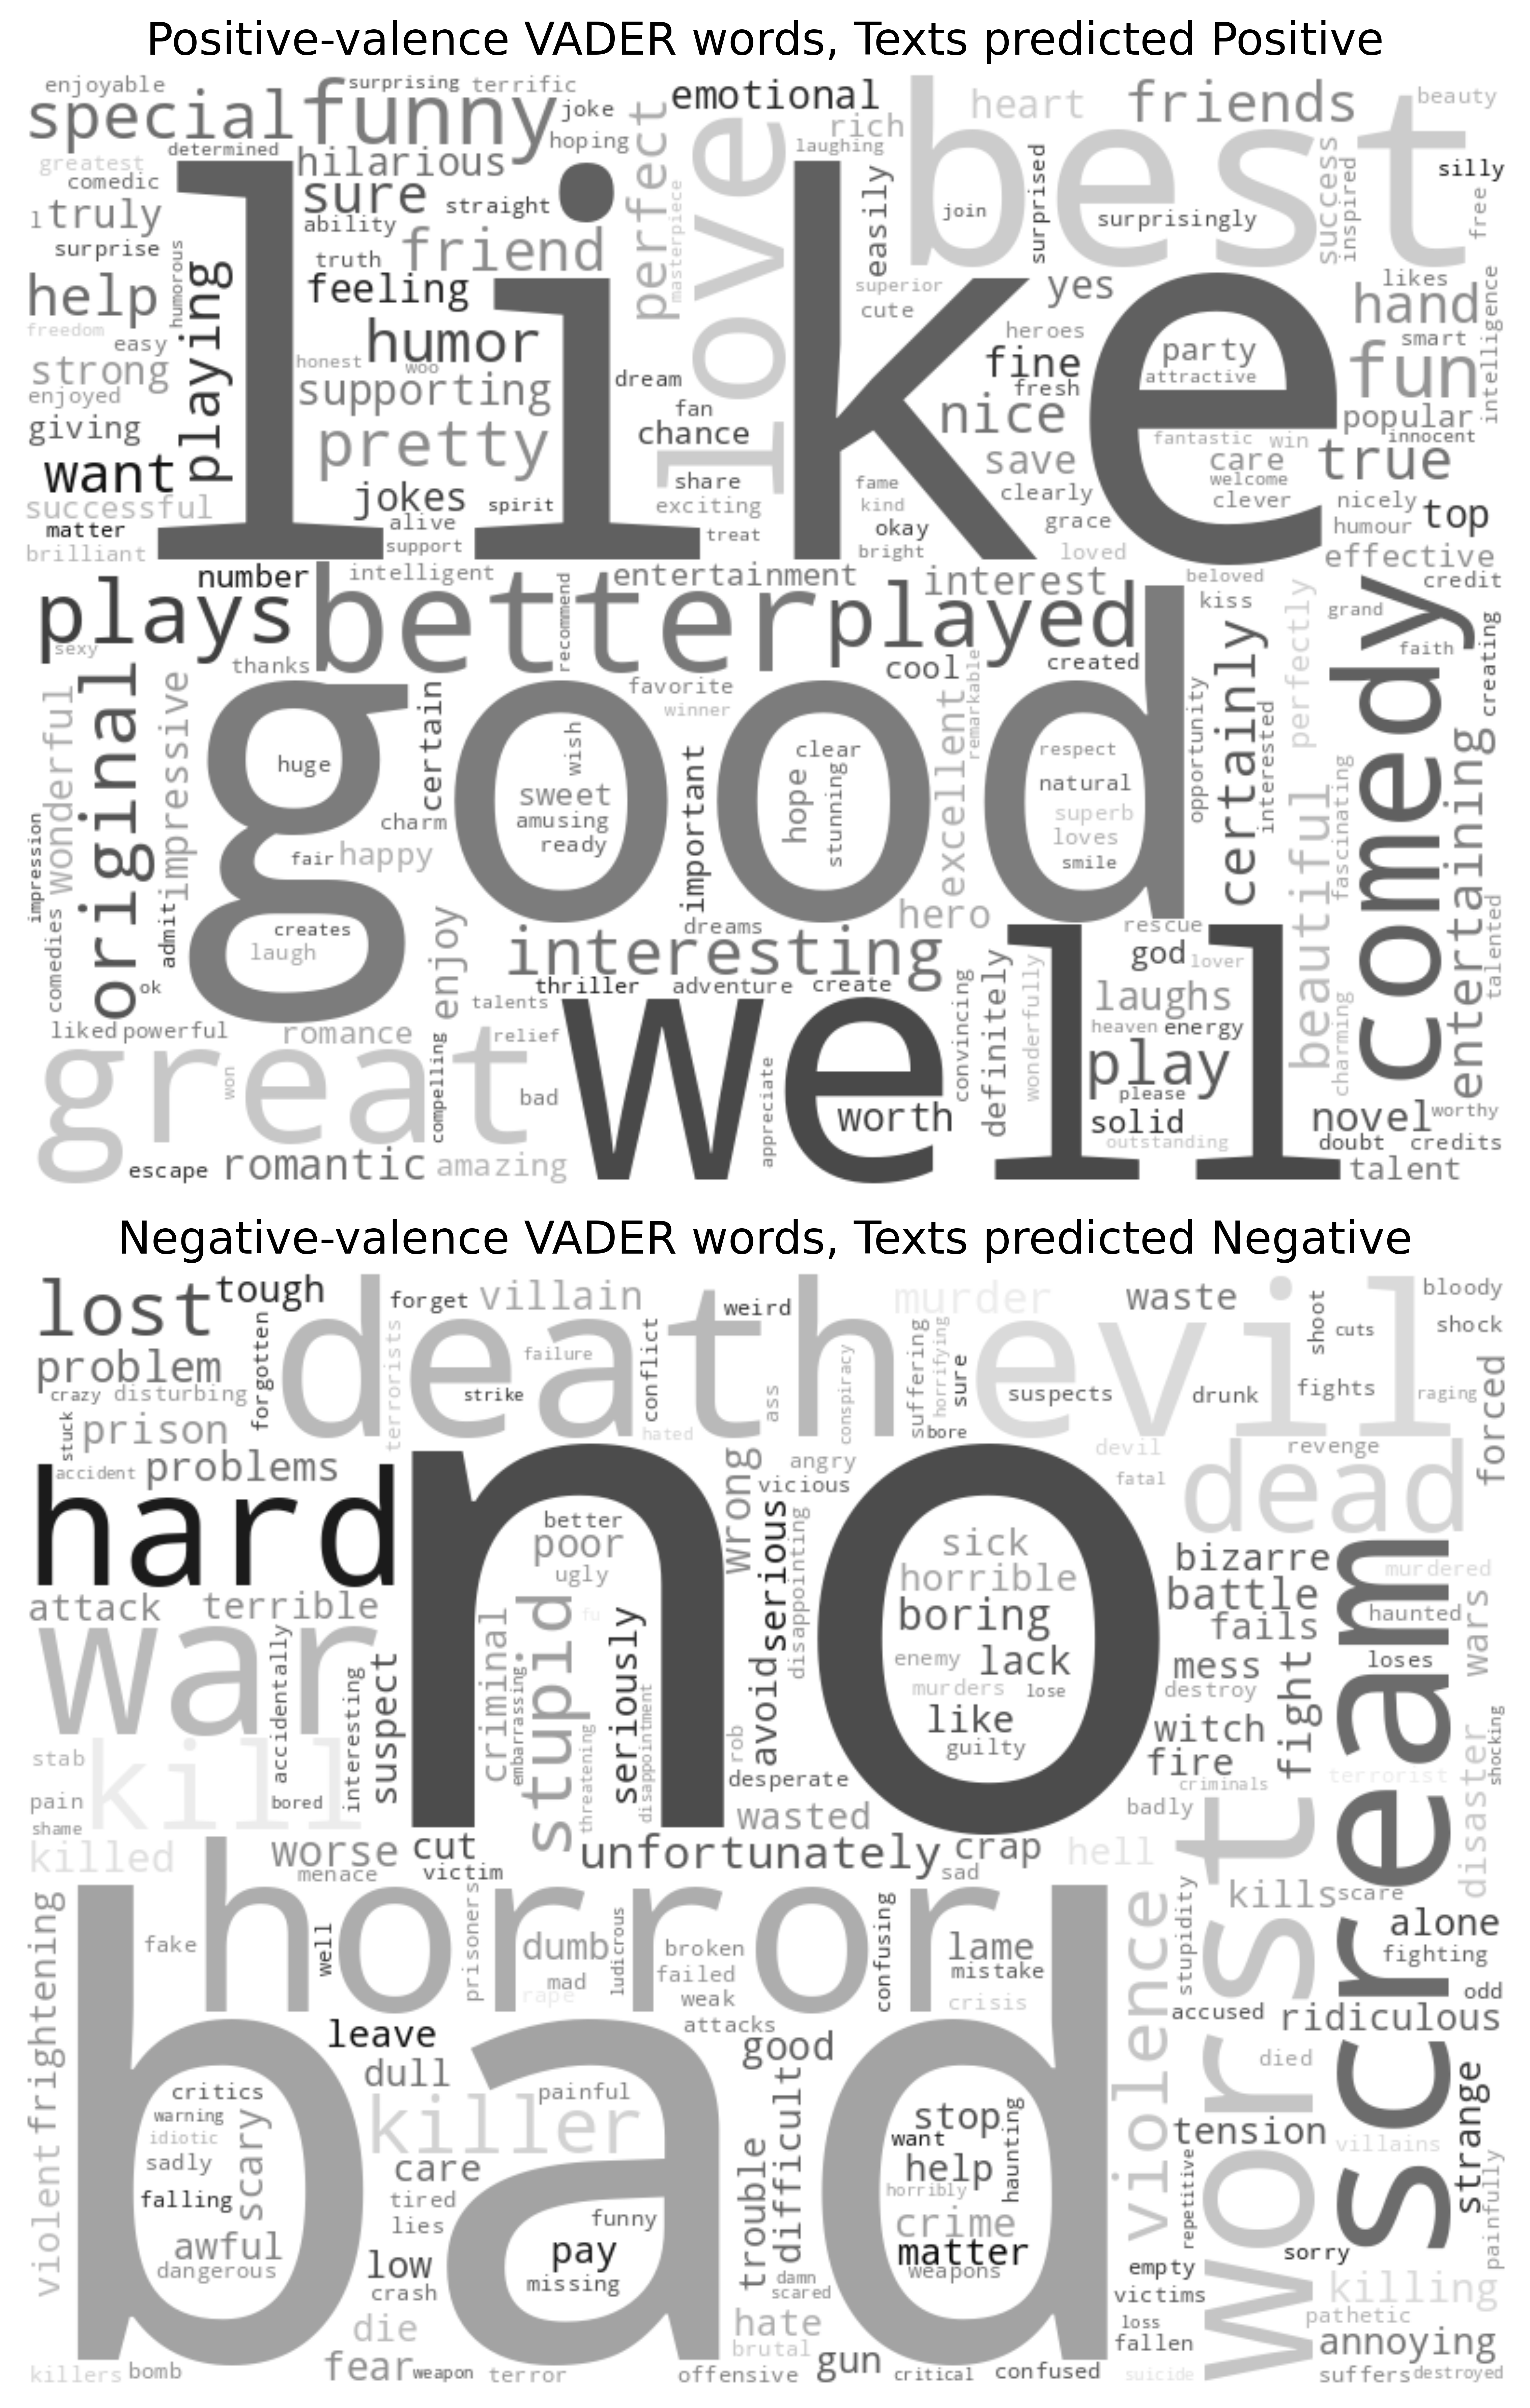

In [24]:
sentiment_wordcloud(X_train, plot_mode = 'class_valence')

### 6.1 Questions

Examine the word cloud and try different options using the `plot_mode` parameter. We're looking at this as one of our last tasks in the lab, but this might be a helpful exploratory step at the start of a research process to determine how sentiment is expressed in a corpus and identify potential challenges. 

1. What do you observe from the word clouds?  
2. How does it complement some of the analysis you've done in this notebook?

## 7. Wrapping up

This [Sentiment Analysis "Space" on Huggingface](https://huggingface.co/spaces/Bonosa2/SentimentAnalysis) provides a graphical user interface to test sentiment analysis using a transformer-based model. The specific model used is [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english). Try out some of the sentences from the movie review example above. Try other texts you have tested during the lab.  

Here are some questions to consider:
1. How do these models perform compared with VADER?  
2. What are some of the advantages and disadvantages of using pre-trained machine learning models?

<details><summary>Click to expand after answering the questions above</summary>If you are using a "black-box" classifier or planning to train a classifier, using an interpretable approach alongside it (like VADER) can be helpful to understand the texts you are working with and specific challenges related to the texts you are working with. </details>

**Discussion:** Review what you have found with someone in the class or start a forum discussion.

**If you have time**, you could build on what you've learned about the movie review texts and try to improve upon the classifiers in this notebook using different features or techniques from other labs.